# Spatiotemporal Data Mining of Micromobility Data in Minneapolis
## Final Project

### Luke Zaruba
#### GEOG-5543: Advanced Geocomputing

##### December 13, 2022


<i>Micromobility has been a recent interest of transportation planners and urban residents alike. The most common implementation of micromobility in Minneapolis has been through motorized scooters from companies like Lime (Uber), Bird, or Lyft. There are comprehensive datasets available containing trip information for all scooters within the City, but using the data for understanding travel patterns and user behaviors have largely remained untouched. The data could have immense value to planners, residents, and other stakeholders, to inform future decision-making and more adequately prepare for how the urban landscape will change to accommodate greater volumes of scooters and other forms of micromobility. My solution is to use the powerful techniques of spatial data science to uncover these patterns and understand how users currently use the scooters.</i>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.cluster import DBSCAN

import requests
import json
import datetime

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import contextily

import h3

import ipywidgets as widgets
from IPython.display import IFrame

%matplotlib inline

## 1. Data Wrangling

The ETL process for this analysis was fairly straighforward, consisting of: loading datasets into DataFrames/GeoDataFrames, casting to different data types, filtering out unnecessary data and columns, and geometry transformations. After the initial cleaning of the data, the nonspatial trips dataset is then jioned to the spatial centerlines dataset. This allows us to associate coordinates with each origin and destination. The final step is some additional cleaning that occurs on the joined DataFrame.

### 1.1. Scooter Data ETL

In [3]:
raw_trips = pd.read_csv("Motorized_Foot_Scooter_Trips_2020.csv")

In [4]:
# Cleaning Trips data
def cleanTripsDF(df):
    # Transforming Time Fields
    df["StartTime"] = pd.to_datetime(df["StartTime"])
    df["EndTime"] = pd.to_datetime(df["EndTime"])

    # Filtering Out Trails
    df_noTrails = df.loc[df["StartCenterlineType"] == "street"]
    df_noTrails = df_noTrails.loc[df_noTrails["EndCenterlineType"] == "street"]
    
    return df_noTrails

In [5]:
cleaned_df = cleanTripsDF(raw_trips)

cleaned_df.head()

ObjectId  TripID  TripDuration  TripDistance                 StartTime  \
0         1    1000           296           675 2020-07-15 14:29:59+00:00   
1         2   54334          1515          4455 2020-07-16 14:29:59+00:00   
2         3   54333           400            27 2020-07-16 15:59:59+00:00   
3         4   54328           445           720 2020-07-16 15:59:59+00:00   
4         5   54332           172            55 2020-07-16 15:59:59+00:00   

                    EndTime StartCenterlineID StartCenterlineType  \
0 2020-07-15 15:00:00+00:00          16901.00              street   
1 2020-07-16 15:00:00+00:00          17051.00              street   
2 2020-07-16 15:59:59+00:00          16633.00              street   
3 2020-07-16 16:30:00+00:00          15151.00              street   
4 2020-07-16 15:59:59+00:00          16714.00              street   

  EndCenterlineID EndCenterlineType  
0        16901.00            street  
1        17246.00            street  
2        15151.00            street  
3        15151.00            street  
4        16714.00            street

### 1.2. Road Data

In [6]:
# Data Extraction of Spatial Data
def getSpatialData(url):
    # Request Data
    resp = requests.get(url)
    json_response = json.dumps(resp.json())
    
    # Read in JSON, Set CRS
    gdf = gpd.read_file(json_response)
    gdf.set_crs("EPSG:4326")
    
    # Eliminate Unnecessary Fields and Reproject
    gdf = gdf[["GBSID", "geometry"]]

    # Calculate Centroid and Set Geometry
    gdf["centroid"] = gdf.centroid
    gdf = gdf.drop(["geometry"], axis=1)
    gdf = gdf.set_geometry("centroid")
    
    return gdf

In [7]:
roads_url = r"https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/MPLS_Centerline/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

roads_df = getSpatialData(roads_url)

roads_df.head()

GBSID                    centroid
0  10406  POINT (-93.28497 45.01759)
1  25251  POINT (-93.22865 44.98654)
2  17632  POINT (-93.24588 44.98387)
3  25962  POINT (-93.27726 44.97850)
4  20888  POINT (-93.22566 44.92779)

### 1.3. Joining Nonspatial & Spatial Data

In [8]:
# Joining Spatial and Nonspatial Data
def joinTripsToRoads(trips, roads):
    # Converting Centerline Data Types to Ints
    trips = trips.astype({"StartCenterlineID": "float", "EndCenterlineID": "float"})
    trips = trips.astype({"StartCenterlineID": "int64", "EndCenterlineID": "int64"})
    
    # Perform Join on Origin
    joined = trips.merge(roads, how = "left", left_on = "StartCenterlineID", right_on = "GBSID")
    joined = joined.rename(columns={"centroid":"OriginPt", "GBSID":"OriginID"})
    
    # Perform Join on Destination
    final = joined.merge(roads, how = "left", left_on = "EndCenterlineID", right_on = "GBSID")
    final = final.rename(columns={"centroid":"DestPt", "GBSID":"DestID"})
    
    return final

# Further Processing on the Joined Dataset
def cleanJoined(df):
    # Dropping NaNs
    df = df.dropna(subset=["OriginPt", "DestPt"])
    
    # Calculating New Time Fields
    df['day_of_year'] = df['StartTime'].dt.dayofyear
    df['start_hour'] = df['StartTime'].dt.hour
    df['end_hour'] = df['EndTime'].dt.hour
    
    # Getting O/D Lats & Lons
    df['lonOri'] = df.OriginPt.apply(lambda p: p.x)
    df['latOri'] = df.OriginPt.apply(lambda p: p.y)
    df['lonDst'] = df.DestPt.apply(lambda p: p.x)
    df['latDst'] = df.DestPt.apply(lambda p: p.y)
    
    # Filtering Out Unneeded Fields
    final = df[["lonOri", "latOri", "lonDst", "latDst", "day_of_year", "start_hour", "end_hour"]].copy()
    
    return final
    

In [9]:
joined = joinTripsToRoads(cleaned_df, roads_df)

joined_clean = cleanJoined(joined)

joined_clean.head()

lonOri     latOri     lonDst     latDst  day_of_year  start_hour  \
0 -93.278785  44.987328 -93.278785  44.987328          197          14   
1 -93.275411  44.974288 -93.268863  44.978713          198          14   
2 -93.235245  44.978877 -93.235593  44.978232          198          15   
3 -93.235593  44.978232 -93.235593  44.978232          198          15   
4 -93.277625  44.970511 -93.277625  44.970511          198          15   

   end_hour  
0        15  
1        15  
2        15  
3        16  
4        15

## 2. Clustering with DBSCAN

DBSCAN, or Density-Based Spatial Clustering of Applications with Noise, is a clustering algorithm that "finds core samples of high density and expands clusters from them" ([scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), 2022). The primary reason that this model was selected to perform spatiotemporal data mining in this context was due to its ability to classify noise, which other clustering algorithms like K-Means, do not do. The model's implementation was simple, as can be seen by the code, of which only three lines are actually reaquired at a bare minimum. For more information on DBSCAN, scikit-learn offers a [guide](https://scikit-learn.org/stable/modules/clustering.html#dbscan) that breaks down the basics of DBSCAN and other clustering algorithms, as well.

In [10]:
# Create DBSCAN Model
def dbscanModel(df, ep=0.001, minSamp=10):
    # Create Model
    model = DBSCAN(eps=ep, min_samples=minSamp)
    
    # Fit Model
    model.fit(df[["lonOri", "latOri", "lonDst", "latDst", "start_hour", "end_hour"]])

    # Add Labels to DF
    df["labels"] = model.labels_

    # Filter out Noise
    dfNoiseFree = df.loc[df.labels != -1]

    # Convert Labels to Strings for Easy Display
    dfNoiseFree["labels"] = dfNoiseFree["labels"].astype(str)
    
    return dfNoiseFree, df

In [11]:
modelDF, modelDF_wNoise = dbscanModel(joined_clean)

## 3. Visualization

Data visualization is of the utmost importance when exploring spatial data, but when the temporal dimension is added, things can get complicated quite easily. There are a multitude of options for different techniques to visualize spatiotemporal data, but ultimately there are not a ton of options within Python, making this an area that I would deem to be an important area of focus for the geospatial open-source development community. Although there are plenty of options to visualize spatial data, and a larger amount that can visualixe multimdimensional data quite well, when these two are combined together the options are limited.

With this is mind, I decided to display the data a few differnt ways, as described below.
1. Plotly 3D Scatterplot
2. Matplotlib 3D Line Plot
3. Matplotlib (& Contextily) Static 2D Cluster Map
4. Seaborn Animated Time Series KDEPlot

Each of these plot types has their own pros and cons, but ultimately there is no existing package in Python that combines the best parts of each of these plots.

In the future, I think there several ways that visualization could be improved, which are listed below.
1. Integration with Uber's H3
2. Using Voxels (like Esri's Space-Time Cube)
3. Animated Flow Maps
4. Animated Vector Fields
5. 3D Scatter/Line Plots with Geospatial Context (like Plotly with geospatial context embedded within it)

Additionally, here are some exciting projects that are making progess in the field of spatiotemporal visualization.
- [VASA](https://github.com/move-ucsb/VASA)
- [DynamoVis](https://github.com/move-ucsb/DynamoVis)
- [MovingPandas](https://github.com/anitagraser/movingpandas)
- [TransBigData](https://github.com/ni1o1/transbigdata)
- [scikit-mobility](https://github.com/scikit-mobility/scikit-mobility)
- [FlowMapper](https://flowmapper.org)
- [kepler.gl](https://docs.kepler.gl)


In [12]:
# Create New DFs Containing Origins and Destinations, Seperately
origin_df = modelDF_wNoise[["lonOri", "latOri", "start_hour"]].copy()
destination_df = modelDF_wNoise[["lonDst", "latDst", "end_hour"]].copy()

In [13]:
# Plots the Clusters in 3D (spatiotemporal), using Plotly
def plotly3DPlot(df, tField, origin=True):
    # Make Plot if Origin is Used
    if origin == True:
        fig = px.scatter_3d(df, x = "lonOri", y = "latOri", z = tField, color = "labels")
    # Make Plot if Destination is Used
    else:
        fig = px.scatter_3d(df, x = "lonDst", y = "latDst", z = tField, color = "labels")
    
    # Displaying plot
    fig.show()


# Static MPL Plot showing OD Flow Patterns
def flowPlot(df, save=False):
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection= "3d")
    
    for _, r in df.iterrows():
        x = [r["lonOri"], r["lonDst"]]
        y = [r["latOri"], r["latDst"]]
        z = [r["start_hour"], r["end_hour"]]
        
        ax.plot(x, y, z)
    
    plt.title(f"Clustered Origin-Destination Flows")
    
    # Saving output as PNG
    if save == True:
        plt.savefig("flows.png")
    
    # Displaying plot
    plt.show()


# Plot Results with Spatial Context
def staticMap(df, origin=True, save=False):
    # Setting Fields Based on Origin Choice
    if origin == True:
        lon = "lonOri"
        lat = "latOri"
    else:
        lon = "lonDst"
        lat = "latDst" 
    
    # Set up Fig
    f, ax = plt.subplots(1, figsize=(12, 12))

    # Plot Noise
    noise = df.loc[df.labels == -1]
    ax.scatter(noise[lon], noise[lat], c = "grey", s = 3, linewidth = 0)
    
    # Plot Clusters
    ax.scatter(df.loc[df.index.difference(noise.index), lon],
        df.loc[df.index.difference(noise.index), lat],
        c = "Blue",
        #c = df.loc[df.index.difference(noise.index), "labels"],
        #cmap = "Set1",
        s = 20,
        linewidth = 0,
    )

    # Add Basemap
    contextily.add_basemap(ax, source = contextily.providers.CartoDB.Voyager, crs = "EPSG:4326")

    ax.set_axis_off()

    # Saving output as PNG
    if save == True:
        plt.savefig("cluster_map.png")

    # Displaying plot
    plt.show()

### 3.1. Plotly

In [14]:
# Plotting Clusters with Origin Lat/Lon and Day of Year
plotly3DPlot(modelDF, "start_hour")

In [15]:
# Plotting Clusters with Destination Lat/Lon and Day of Year
plotly3DPlot(modelDF, "end_hour", False)

### 3.2. Matplotlib

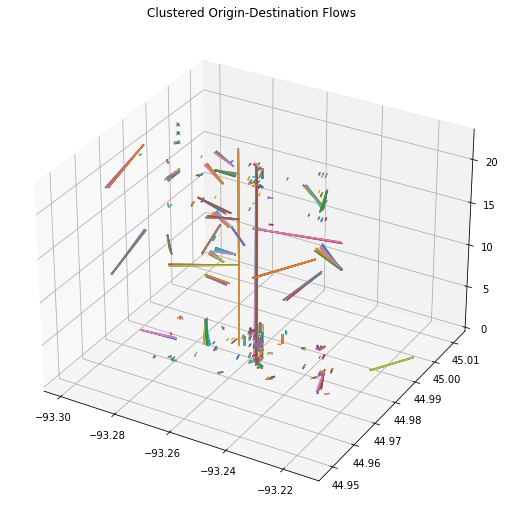

In [16]:
# Flow Plot
flowPlot(modelDF, True)

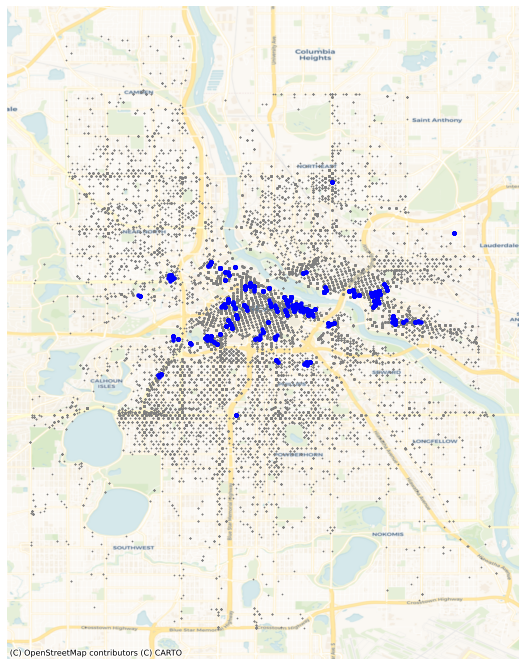

In [17]:
# Origin Clusters
staticMap(modelDF_wNoise, save=True)

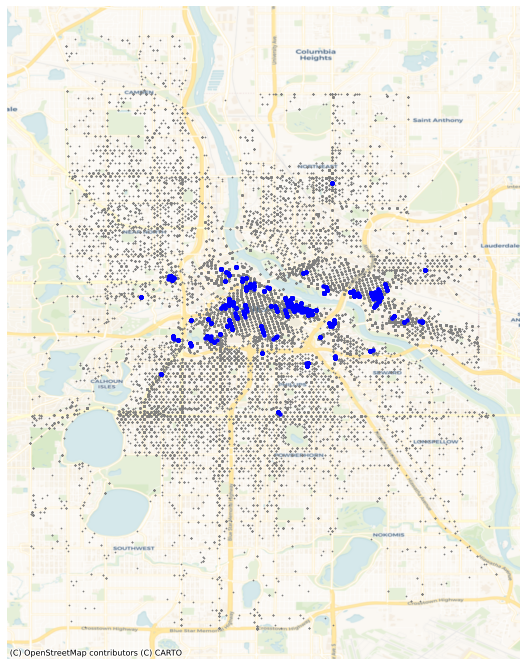

In [18]:
# Destination Clusters
staticMap(modelDF_wNoise, False, True)

### 3.3. Seaborn

In [19]:
# Example Animated Time Series KDE (using origins DF)
def plotKDE(t=0):
    # Filtering by time
    plottingDF = origin_df.loc[origin_df["start_hour"] == t]
    
    # Creating Plot
    fig, ax = plt.subplots(figsize=(25,15))
    kde = sns.kdeplot(x='lonOri', y='latOri', data=plottingDF, ax=ax, shade=True, alpha = 0.5, cbar=True, cmap="icefire")
    #kde.fig.suptitle("Map Title", fontsize=16)
    # Adding Basemap Layer to Plot
    contextily.add_basemap(kde, crs="EPSG:4326", source=contextily.providers.Stamen.TonerLite)
    
widgets.interact(plotKDE, t=widgets.Play(min=0, max=24))

interactive(children=(Play(value=0, description='t', max=24), Output()), _dom_classes=('widget-interact',))

<function __main__.plotKDE(t=0)>

Script to export image of each plot by hour...

<code>
# Exporting Images
for i in range(0, 24):
    plottingDF = destination_df.loc[destination_df["end_hour"] == i]
    # Creating Plot
    fig, ax = plt.subplots(figsize=(25,15))
    kde = sns.kdeplot(x='lonDst', y='latDst', data=plottingDF, ax=ax, shade=True, alpha = 0.5, cbar=True, cmap="icefire")
    #kde.fig.suptitle("Map Title", fontsize=16)
    # Adding Basemap Layer to Plot
    contextily.add_basemap(kde, crs="EPSG:4326", source=contextily.providers.Stamen.TonerLite)
    # Saving
    #plt.savefig(f"dst_kde_{i}.png")
</code>

### 3.4. H3 Integration

In [20]:
# Function to Aggregate by H3 Cell and Time
def aggByH3(df, latFld, lngFld, time, h3_res=8):
    # Add H3 Column
    df["h3_index"] = df.apply(lambda r: h3.geo_to_h3(lat=r[latFld], lng=r[lngFld], resolution=h3_res), axis=1)
    
    # Group By H3 and Time
    df = df.groupby(["h3_index", time]).count()
    
    # Clean Up Output
    df = df[[latFld]].copy()
    df = df.rename(columns={latFld: 'count'})
    
    return df

In [21]:
# Aggregating by H3
origin_h3 = aggByH3(origin_df, "latOri", "lonOri", "start_hour")
destination_h3 = aggByH3(destination_df, "latDst", "lonDst", "end_hour")

In [22]:
# Origin Counts by H3 Cell
print("Origin Top Cells")
print(origin_h3.sort_values(["count"], ascending=False).head())

# Destination Counts by H3 Cell
print("\n" + "Destination Top Cells")
print(destination_h3.sort_values(["count"], ascending=False).head())

Origin Top Cells
                            count
h3_index        start_hour       
882752689dfffff 21           1543
                0            1374
8827526899fffff 0            1283
882752689dfffff 18           1209
8827526899fffff 21           1068

Destination Top Cells
                          count
h3_index        end_hour       
882752689dfffff 21         1342
                0          1168
                18         1096
8827526899fffff 0          1017
                3          1003


In [23]:
# Website source: https://wolf-h3-viewer.glitch.me

# Use the search in the website to identify H3 cells
# Simply copy & paste an H3 index from the cell output above

IFrame('https://wolf-h3-viewer.glitch.me', width=970, height=500)